In [1]:
import os
import pandas as pd
import sys
import numpy as np
import seaborn as sns
import time
from tqdm import tqdm

import torch
import torchvision.models as models
from ptflops import get_model_complexity_info

from itertools import product

from src.train.config import Config as ModelConfig
from src.models.pct.point_transformer_cls import get_model as get_pct, get_loss as get_pct_loss
from src.models.pt.model import get_model as get_pt, get_loss as get_pt_loss

# sys.path.append('src')

In [2]:
for i in range(1, 5):
    fp = os.path.join("outputs/test", str(i), "progress.csv")
    df = pd.read_csv(fp)
    print(max(df["V_Accuracy"]))

0.8946731234866828
0.8595641646489104
nan
nan


In [4]:

device = 'cpu'

def get_model(model_name, method, num_points, num_class, input_dim, init_hidden_dim, k, device,further_ds=0):
    model_config = ModelConfig(method, num_points, num_class, input_dim, init_hidden_dim, k,tome_further_ds=1.000-further_ds)
    # print(model_config.tome_further_ds)
    if model_name == "pct":
        model = get_pct(model_config).float().to(device)
        loss_fn = get_pct_loss()
    elif model_name == "pt":
        model = get_pt(model_config).float().to(device)
        loss_fn = get_pt_loss()
    else:
        raise ValueError(f"The provided model_name is not supported: {model_name}")
    
    return model, loss_fn

# model, _ = get_model(
#             model_name='pt', 
#             method='tome_ft', 
#             num_points=1024,
#             num_class=40,
#             input_dim=3,
#             init_hidden_dim=256,
#             k=32,  
#             device='cuda:1',
#             further_ds=0.1,
#         )

# input_tensor = torch.rand(32, 1024, 3).to('cuda:1')
# model(input_tensor)


In [4]:
sys.path.append('src/train')

# from train_model import get_model

model, _ = get_model(
    "pct", 
    "tome_ft", 
    1024,
    40,
    3,
    64,
    32,  
    device
)

input_tensor = torch.rand(32, 1024, 3).to(device)
flops, params = get_model_complexity_info(model, (1024, 3), as_strings=True, print_per_layer_stat=True)

print('FLOPs:', flops)
print('Parameters:', params)

PCT(
  2.82 M, 102.381% Params, 557.79 MMac, 99.836% MACs, 
  (conv1): Conv1d(192, 0.007% Params, 196.61 KMac, 0.035% MACs, 3, 64, kernel_size=(1,), stride=(1,), bias=False)
  (conv2): Conv1d(4.1 k, 0.149% Params, 4.19 MMac, 0.751% MACs, 64, 64, kernel_size=(1,), stride=(1,), bias=False)
  (bn1): BatchNorm1d(128, 0.005% Params, 131.07 KMac, 0.023% MACs, 64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(128, 0.005% Params, 131.07 KMac, 0.023% MACs, 64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (downsample1): TOME(
    8.45 k, 0.307% Params, 4.39 MMac, 0.786% MACs, 
    (merge): Merge(0, 0.000% Params, 0.0 Mac, 0.000% MACs, )
    (conv): Conv1d(8.19 k, 0.298% Params, 4.19 MMac, 0.751% MACs, 64, 128, kernel_size=(1,), stride=(1,), bias=False)
    (bn): BatchNorm1d(256, 0.009% Params, 131.07 KMac, 0.023% MACs, 128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(0, 0.000% Params, 65.54 KMac, 0.0

In [5]:
model, _ = get_model(
    "pt", 
    "tome_xyz", 
    1024,
    40,
    3,
    32,
    16,  
    device
)

input_tensor = torch.rand(32, 1024, 3).to(device)
flops, params = get_model_complexity_info(model, (1024, 3), as_strings=True, print_per_layer_stat=True)

# print('FLOPs:', flops)
# print('Parameters:', params)

print(flops)

PointTransformerCls(
  7.91 M, 100.000% Params, 2.34 GMac, 99.921% MACs, 
  (backbone): Backbone(
    7.76 M, 98.098% Params, 2.34 GMac, 99.915% MACs, 
    (fc1): Sequential(
      1.18 k, 0.015% Params, 1.25 MMac, 0.053% MACs, 
      (0): Linear(128, 0.002% Params, 131.07 KMac, 0.006% MACs, in_features=3, out_features=32, bias=True)
      (1): ReLU(0, 0.000% Params, 32.77 KMac, 0.001% MACs, )
      (2): Linear(1.06 k, 0.013% Params, 1.08 MMac, 0.046% MACs, in_features=32, out_features=32, bias=True)
    )
    (transformer1): MyAttention2(
      1.35 M, 17.014% Params, 1.38 GMac, 58.854% MACs, 
      (fc1): Linear(16.9 k, 0.214% Params, 17.3 MMac, 0.739% MACs, in_features=32, out_features=512, bias=True)
      (fc2): Linear(16.42 k, 0.208% Params, 16.81 MMac, 0.718% MACs, in_features=512, out_features=32, bias=True)
      (fc_gamma): Sequential(
        525.31 k, 6.645% Params, 538.44 MMac, 22.999% MACs, 
        (0): Linear(262.66 k, 3.322% Params, 268.96 MMac, 11.488% MACs, in_featur

In [6]:

time_dict = dict()

for model_name in ["pct", "pt"]:
    time_dict[model_name] = dict()

    if model_name == "pct":
        hidden_size = 64
        k = 32
    else:
        hidden_size = 32
        k = 16

    for strat,downsample in product(["normal", "tome_ft", "tome_xyz", "random"],[0.0]):
        model, _ = get_model(
            model_name=model_name, 
            method=strat, 
            num_points=1024,
            num_class=40,
            input_dim=3,
            init_hidden_dim=hidden_size,
            k=k,  
            device=device,
            # further_ds=downsample
        )

        N = 7
        times = list()
        for i in range(N):
            input = torch.rand(16, 1024, 3).to(device)
            start = time.time()
            model(input)
            end = time.time()
            times.append(end - start)

        times = np.array(times)
        time_dict[model_name][strat] = times
            

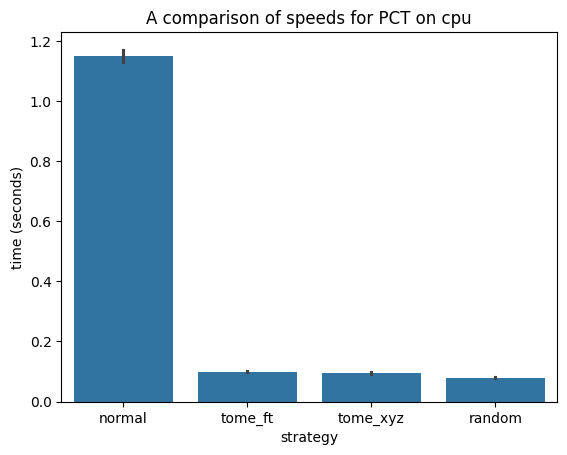

In [7]:
melted = pd.DataFrame(time_dict).reset_index().melt(id_vars = 'index').explode(column='value').reset_index(drop=True)
melted 
ax = sns.barplot(melted[melted['variable'] == 'pct'],x='index',y='value')
ax.set(xlabel='strategy', ylabel='time (seconds)')
ax.set(title=f'A comparison of speeds for PCT on {device}')
ax.get_figure().savefig(f'figures/prune_speeds_pct_{device}.png')

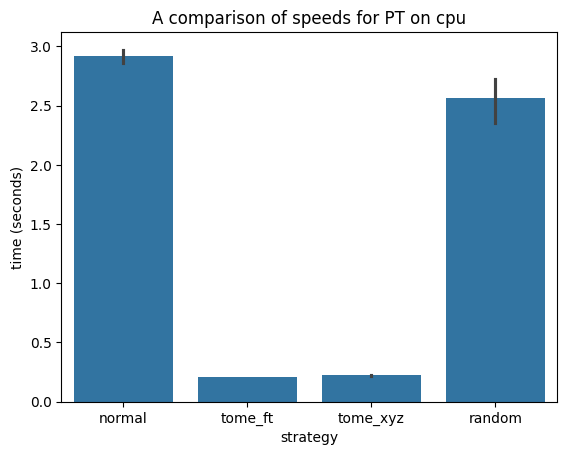

In [8]:
ax = sns.barplot(melted[melted['variable'] == 'pt'],x='index',y='value')
ax.set(xlabel='strategy', ylabel='time (seconds)')
ax.set(title=f'A comparison of speeds for PT on {device}')
ax.get_figure().savefig(f'figures/prune_speeds_pt_{device}.png')

In [5]:
rows = []
models = ["pt",'pct']
devices = ['cuda','cpu']
method =["normal", "tome_ft"]
further_ds = [0.0, 0.15, 0.3]
N_samples = 7 

pbar = tqdm(total=len(models)*len(devices) * len(method) * len(further_ds) * N_samples)
for model_name,device  in product(models, devices):
    # time_dict2[model_name] = dict()

    if model_name == "pct":
        hidden_size = 128
        k = 32
    else:
        hidden_size = 64
        k = 16

    for strat,downsample in product(["normal", "tome_ft",],[0.0, 0.15, 0.3]):
        model, _ = get_model(
            model_name=model_name, 
            method=strat, 
            num_points=1024,
            num_class=40,
            input_dim=3,
            init_hidden_dim=hidden_size,
            k=k,  
            device=device,
            further_ds=downsample
        )
        # print(torch.cuda.memory_allocated(device='cuda'))

        with torch.no_grad(): 
            input_tensor = torch.rand(32, 1024, 3).to(device)
            flops, params = get_model_complexity_info(model, (1024, 3), as_strings=False, print_per_layer_stat=False)
            # print(torch.cuda.memory_allocated(device='cuda'))

            input_tensor = input_tensor.cpu()
            # print(torch.cuda.memory_allocated(device='cuda'))

            for i in range(N_samples):
                input_ = torch.rand(16, 1024, 3).to(device)
                start = time.time()
                model(input_)
                end = time.time()
                # times.append(end - start)
                # print(torch.cuda.memory_allocated(device='cuda'))
                rows.append({
                    'device':device,
                    'model':model_name, 
                    'strategy':strat,
                    'downsample':downsample,
                    'flops':flops,
                    # 'params':params,
                    'time':end - start,
                })
                pbar.update(n=1)
            # print(torch.cuda.memory_allocated(device='cuda'))

        input_ = input_.cpu() 
        model = model.to('cpu')
        del _ 
        del input_tensor
        # print(torch.cuda.memory_allocated(device='cuda'))

del model

  0%|          | 0/168 [00:09<?, ?it/s]


In [6]:
# del model, input_, input_tensor, _ 
print(torch.cuda.memory_allocated(device='cuda'))


8519680


In [25]:
del model

In [7]:
df_sample = pd.DataFrame(rows)
df_sample[['time','flops']] = df_sample[['time','flops']].astype(float)

masks = [(df_sample['model'] == model_) & (df_sample['device'] == device_) for model_, device_ in product(models,devices)]
for mask in masks: 
    bases = df_sample[mask & (df_sample.strategy == 'normal') & (df_sample.downsample == 0.00)]
    bases = bases[['time','flops',]].mean()

    df_sample.loc[mask,['time','flops']] = df_sample.loc[mask,['time','flops']] / bases

df_sample

,device,model,strategy,downsample,flops,time
0,cuda,pt,normal,0.0,1.000000,2.164204
1,cuda,pt,normal,0.0,1.000000,0.819420
2,cuda,pt,normal,0.0,1.000000,0.816034
3,cuda,pt,normal,0.0,1.000000,0.805402
4,cuda,pt,normal,0.0,1.000000,0.797579
...,...,...,...,...,...,...
163,cpu,pct,tome_ft,0.3,0.129204,0.052032
164,cpu,pct,tome_ft,0.3,0.129204,0.052341
165,cpu,pct,tome_ft,0.3,0.129204,0.052993
166,cpu,pct,tome_ft,0.3,0.129204,0.052489


/tmp/ipykernel_943792/1796915253.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(


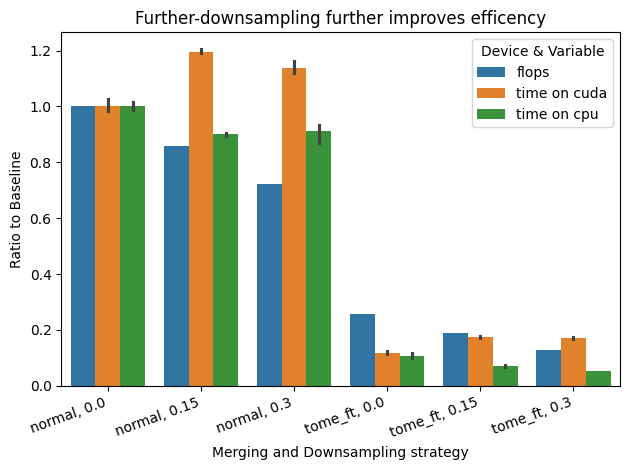

In [9]:
# melted2 = pd.DataFrame(time_dict2).reset_index().rename(columns={'level_0':'agg','level_1':'downsample'}).explode(column=['pct','pt']).melt(id_vars = ['agg','downsample']).rename(columns={'value':'Time'})#.explode(column='value').reset_index(drop=True)
melted2 = df_sample.rename(columns={'strategy':'agg'}).melt(id_vars=['model','agg','downsample','device'],value_name='Ratio to Baseline')
melted2['Merging and Downsampling strategy'] = melted2.apply((lambda row: (f'{row["agg"]}, {row["downsample"]}')),axis=1)
melted2['Device & Variable'] = melted2.apply((lambda row: f'{row["variable"]} on {row["device"]}' if row['variable'] !='flops' else 'flops'),axis=1)
ax = sns.barplot(melted2[melted2['model'] == 'pct'],x='Merging and Downsampling strategy',y='Ratio to Baseline',hue='Device & Variable')
ax.set(title=f'Further-downsampling further improves efficency')
ax.set_xticklabels(
    ax.get_xticklabels(), 
    rotation=20, 
    horizontalalignment='right'
)
ax.get_figure().tight_layout()
ax.get_figure().savefig(f'figures/downsample_speeds_pct_both_devs.png')
print()
# melted2

/tmp/ipykernel_942082/1160579061.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(


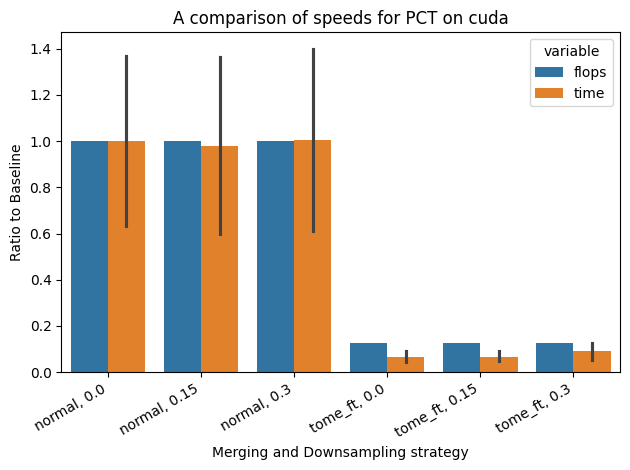

In [12]:
# ax.set(xlabel='strategy', ylabel='time (seconds)')
ax = sns.barplot(melted2[melted2['model'] == 'pt'],x='Merging and Downsampling strategy',y='Ratio to Baseline',hue='variable')
ax.set(title=f'A comparison of speeds for PCT on {device}')
ax.set_xticklabels(
    ax.get_xticklabels(), 
    rotation=30, 
    horizontalalignment='right'
)
ax.get_figure().tight_layout()
ax.get_figure().savefig(f'figures/downsample_speeds_pt_{device}.png')
print()

In [14]:
melted2

,model,agg,downsample,device,variable,Ratio to Baseline,Merging and Downsampling strategy
0,pct,normal,0.0,cpu,flops,1.000000,"normal, 0.0"
1,pct,normal,0.0,cpu,flops,1.000000,"normal, 0.0"
2,pct,normal,0.0,cpu,flops,1.000000,"normal, 0.0"
3,pct,normal,0.0,cpu,flops,1.000000,"normal, 0.0"
4,pct,normal,0.0,cpu,flops,1.000000,"normal, 0.0"
...,...,...,...,...,...,...,...
331,pt,tome_ft,0.3,cuda,time,0.023414,"tome_ft, 0.3"
332,pt,tome_ft,0.3,cuda,time,0.023420,"tome_ft, 0.3"
333,pt,tome_ft,0.3,cuda,time,0.023274,"tome_ft, 0.3"
334,pt,tome_ft,0.3,cuda,time,0.023351,"tome_ft, 0.3"
